### Try-it 9.2: Predicting Wages

This activity is meant to summarize your work with regularized regression models.  You will use your earlier work with data preparation and pipelines together with what you've learned with grid searches to determine an optimal model.  In addition to the prior strategies, this example is an excellent opportunity to utilize the `TransformedTargetRegressor` estimator in scikitlearn.

### The Data

This dataset is loaded from the openml resource library.  Originally from census data, the data contains wage and demographic information on 534 individuals. From the dataset documentation [here](https://www.openml.org/d/534)

```
The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership. 
```

In [134]:
from sklearn.datasets import fetch_openml

In [135]:
wages = fetch_openml(data_id=534, as_frame=True)

In [136]:
wages.frame.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8.0,no,female,21.0,not_member,5.10,35.0,Hispanic,Other,Manufacturing,Married
1,9.0,no,female,42.0,not_member,4.95,57.0,White,Other,Manufacturing,Married
2,12.0,no,male,1.0,not_member,6.67,19.0,White,Other,Manufacturing,Unmarried
3,12.0,no,male,4.0,not_member,4.00,22.0,White,Other,Other,Unmarried
4,12.0,no,male,17.0,not_member,7.50,35.0,White,Other,Other,Married


#### Task

Build regression models to predict `WAGE`.  Incorporate the categorical features and transform the target using a logarithm.  Build `Ridge` models and consider some different amounts of regularization.  

After fitting your model, interpret the model and try to understand what features led to higher wages.  Consider using `permutation_importance` that you encountered in module 8.  Discuss your findings in the class forum.

For an in depth example discussing the perils of interpreting the coefficients see the example in scikitlearn examples [here](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html).

In [137]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
import numpy as np
import plotly.express as px
import pandas as pd
import warnings

In [138]:
## Steps

# hot encode categorical variables
# transform target using logarithm -- TransformedTargetRegressor
# Ridge model - grid search good alpha
# fit and predict 
# use more models
# choose best features : SFS, permutation_importance

In [139]:
# Convert to dataframe

df = pd.DataFrame(data = wages.data, columns = wages.feature_names)
df['WAGE'] = pd.Series(wages.target)
df = pd.get_dummies(df, columns = ["MARR", "UNION", "SEX", "SOUTH"], drop_first = True)
df = pd.get_dummies(df, columns = ["RACE", "OCCUPATION", "SECTOR"])
df.drop(columns = ['RACE_Other', 'OCCUPATION_Other', 'SECTOR_Other'], inplace = True, axis = 1)
df.head()

,EDUCATION,EXPERIENCE,AGE,WAGE,MARR_Unmarried,UNION_not_member,SEX_male,SOUTH_yes,RACE_Hispanic,RACE_White,OCCUPATION_Clerical,OCCUPATION_Management,OCCUPATION_Professional,OCCUPATION_Sales,OCCUPATION_Service,SECTOR_Construction,SECTOR_Manufacturing
0,8.0,21.0,35.0,5.10,0,1,0,0,1,0,0,0,0,0,0,0,1
1,9.0,42.0,57.0,4.95,0,1,0,0,0,1,0,0,0,0,0,0,1
2,12.0,1.0,19.0,6.67,1,1,1,0,0,1,0,0,0,0,0,0,1
3,12.0,4.0,22.0,4.00,1,1,1,0,0,1,0,0,0,0,0,0,0
4,12.0,17.0,35.0,7.50,0,1,1,0,0,1,0,0,0,0,0,0,0


Text(0, 0.5, 'Count')

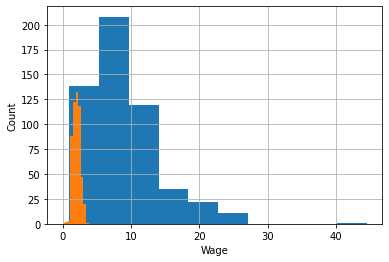

In [140]:
# hot encode categorical variables

X = df.drop('WAGE', axis = 1)
y = df['WAGE']

ax = y.hist()
np.log(y).hist()
ax.set_xlabel('Wage')
ax.set_ylabel('Count')

In [141]:
# Splitting data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [157]:
# Pipeline

# categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
# preprocessor = make_column_transformer(
#     (OneHotEncoder(drop="first"), abc),
#     remainder="passthrough")
pipe = Pipeline([
    ('selector', SequentialFeatureSelector(estimator = LinearRegression(),
                                           scoring = 'neg_mean_squared_error',
                                           n_features_to_select = 5)),
    ('model', TransformedTargetRegressor(regressor = Ridge(alpha = math.e**(-10)), func = np.log, inverse_func = np.exp))
])

pipe.fit(X_train, y_train)
train_preds = pipe.predict(X_train)
test_preds = pipe.predict(X_test)
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)
print(train_mse)
print(test_mse)

19.96832783616951
20.285163444726468


In [158]:
# Best alpha for simple CV

params_dict = {'model__regressor__alpha': np.logspace(-10, 100, 10)}
grid = GridSearchCV(pipe, param_grid=params_dict)
grid.fit(X_train, y_train)
print(grid.best_estimator_)
best_pipe = grid.best_estimator_
train_preds = best_pipe.predict(X_train)
test_preds = best_pipe.predict(X_test)
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)
print(train_mse)
print(test_mse)

Pipeline(steps=[('selector',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=5,
                                           scoring='neg_mean_squared_error')),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Ridge(alpha=1e-10)))])
19.968327593171267
20.285163589547196


In [164]:
grid.best_estimator_.named_steps['model__regressor'].coef_
best_pipe.named_steps['selector'].get_feature_names_out()


KeyError: 'model__regressor'

In [133]:
# Ridge model with SFS
import math

ridge_pipe = Pipeline([('selector', SequentialFeatureSelector(estimator = Linear_Regression(),
                                                             n_features_to_select=4)),
                       ('scaler', StandardScaler()),
                       ('ridge', Ridge(alpha = math.e**(-10)))])

ridge_pipe.fit(X_train, y_train)
train_preds = ridge_pipe.predict(X_train)
test_preds = ridge_pipe.predict(X_test)
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)
print(train_mse)
print(test_mse)
ridge_coefs = ridge_pipe.named_steps['ridge'].coef_
ridge_coefs


NameError: name 'Linear_Regression' is not defined

In [149]:
# Ridge model with PI
import plotly.express as px

r = permutation_importance(pipe, X_test, y_test, random_state = 22)
r.importances_mean

px.bar(x = X_train.columns, y = r.importances_mean, title = 'Importance mean vs Features')


In [156]:
# Pipeline with TransformedTargetRegressor

perm_pipe = Pipeline([('scaler', StandardScaler()),
                       ('model', TransformedTargetRegressor(regressor = Ridge(alpha = math.e**(-10)), func = np.log, inverse_func = np.exp))])

perm_pipe.fit(X_train, y_train)
train_preds = perm_pipe.predict(X_train)
test_preds = perm_pipe.predict(X_test)
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)
print(train_mse)
print(test_mse)
# coefs = perm_pipe.named_steps['model'].coef_
# coefs

18.9268939866718
19.567575375886747
